In qgan 4, let me try a slightly different circuit.

In qgan 4.1, adjust number of layers.

In 4.1.1, adjust the discriminator learning rate a little bit.

4.1.3 is based on 4.1.1 and tries to fix the random generation issue.
4.1.3 not based on 4.1.2

4.1.4 is when you combine what you have for 4.1.2 and 4.1.3

In [89]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import torch
import torch.nn as nn
import torch.utils.data
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import qiskit
from qiskit import QuantumCircuit
from qiskit.circuit.library import EfficientSU2
from qiskit_aer import AerSimulator
from qiskit.circuit import ParameterVector

In [ ]:
REAL_LABEL = 1
FAKE_LABEL = 0
OUT_DIM = 4
Q_PER_SITE = 4
n_qubits = OUT_DIM * Q_PER_SITE

is_local_simulator = True

g_repeats_1  = 1
g_repeats_2  = 4
g_batch_size = 16
d_batch_size = 16

d_repeats = 1

n_epoch = 400
epoch_1 = 150

d_pretrain_epoch = 10

n_layers = 3
final_rotation_layer = True

lr = 4e-4


spsa_alpha = 0.05
spsa_gamma = 0.01
spsa_c     = 0.05
spsa_A     = 2e4
spsa_a1    = 2e-4
spsa_a     = spsa_a1 * (spsa_A + 1) ** spsa_alpha

name = "qgan-4.1.4"

save_folder = f"saved/{name}"

data_path = "images_4s.npy"

seed = 2

max_data = 0.4

In [91]:
## some code to prevent the the output from being saved to the wrong directory

if globals().get("__file__") and os.path.basename(globals["__file__"]) != name + ".py":
    raise UserWarning("The 'name' variable does not match the file name.")
if globals().get("__vsc_ipynb_file__") and os.path.basename(globals().get("__vsc_ipynb_file__")) != name + ".ipynb":
    raise UserWarning("The 'name' variable does not match the file name.")

In [92]:
if os.path.exists(save_folder):
    print(f"This notebook may overwrite previous results in the {save_folder} directory")
else:
    os.makedirs(save_folder)

rng = np.random.default_rng(seed)

# Device configuration
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device("cpu")

random.seed(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)


This notebook may overwrite previous results in the saved/qgan-4.1.4 directory


In [93]:
data_true = np.load(data_path)
data_true = np.clip(data_true, 0, max_data)
rng.shuffle(data_true)
data_true = torch.tensor(data_true, dtype = torch.float32, device=device, requires_grad=False)
data_loader = torch.utils.data.DataLoader(data_true, batch_size=d_batch_size, shuffle = True)

In [94]:
if n_qubits %2 != 0:
    raise ValueError("Odd number of qubits not supported right now.")

n_1q_parameters = 2 * n_qubits * (2 * n_layers + 1) if final_rotation_layer else  2 * n_qubits * (2 * n_layers + 0)
n_2q_parameters = n_qubits * n_layers

n_parameters = n_1q_parameters + n_2q_parameters

print(f"There are {n_1q_parameters} parameters controlling 1-qubit rotations.")
print(f"There are {n_2q_parameters} parameters controlling 2-qubit rotations.")
print(f"Therer are {n_1q_parameters + n_2q_parameters} trainable parameters in the circuit.")

There are 224 parameters controlling 1-qubit rotations.
There are 48 parameters controlling 2-qubit rotations.
Therer are 272 trainable parameters in the circuit.


In [95]:
# par_1q_rots = ParameterVector(r"$\theta$", n_1q_parameters)
# par_2q_rots = ParameterVector(r"$\Theta$", n_2q_parameters)
par_weights = ParameterVector(r"$\theta$", n_parameters)

In [96]:
qc = QuantumCircuit(n_qubits)

for layer in range(n_layers):
    for i in range(n_qubits):
        qc.rx(par_weights[4 * n_qubits * layer + 2*i + 0], i)
        qc.rz(par_weights[4 * n_qubits * layer + 2*i + 1], i)
    for i in range(0, n_qubits, 2):
        qc.rxx(par_weights[n_1q_parameters + n_qubits * layer + i], i, (i+1)%n_qubits)
    for i in range(n_qubits):
        qc.rx(par_weights[2*n_qubits*(2*layer+1) + 2*i + 0], i)
        qc.rz(par_weights[2*n_qubits*(2*layer+1) + 2*i + 1], i)
    for i in range(1, n_qubits, 2):
        qc.rxx(par_weights[n_1q_parameters + n_qubits * layer + i], i, (i+1)%n_qubits)

if final_rotation_layer:
    for i in range(n_qubits):
        qc.rx(par_weights[4*n_qubits*n_layers + 2*i + 0], i)
        qc.rz(par_weights[4*n_qubits*n_layers + 2*i + 1], i)



qc.measure_all()


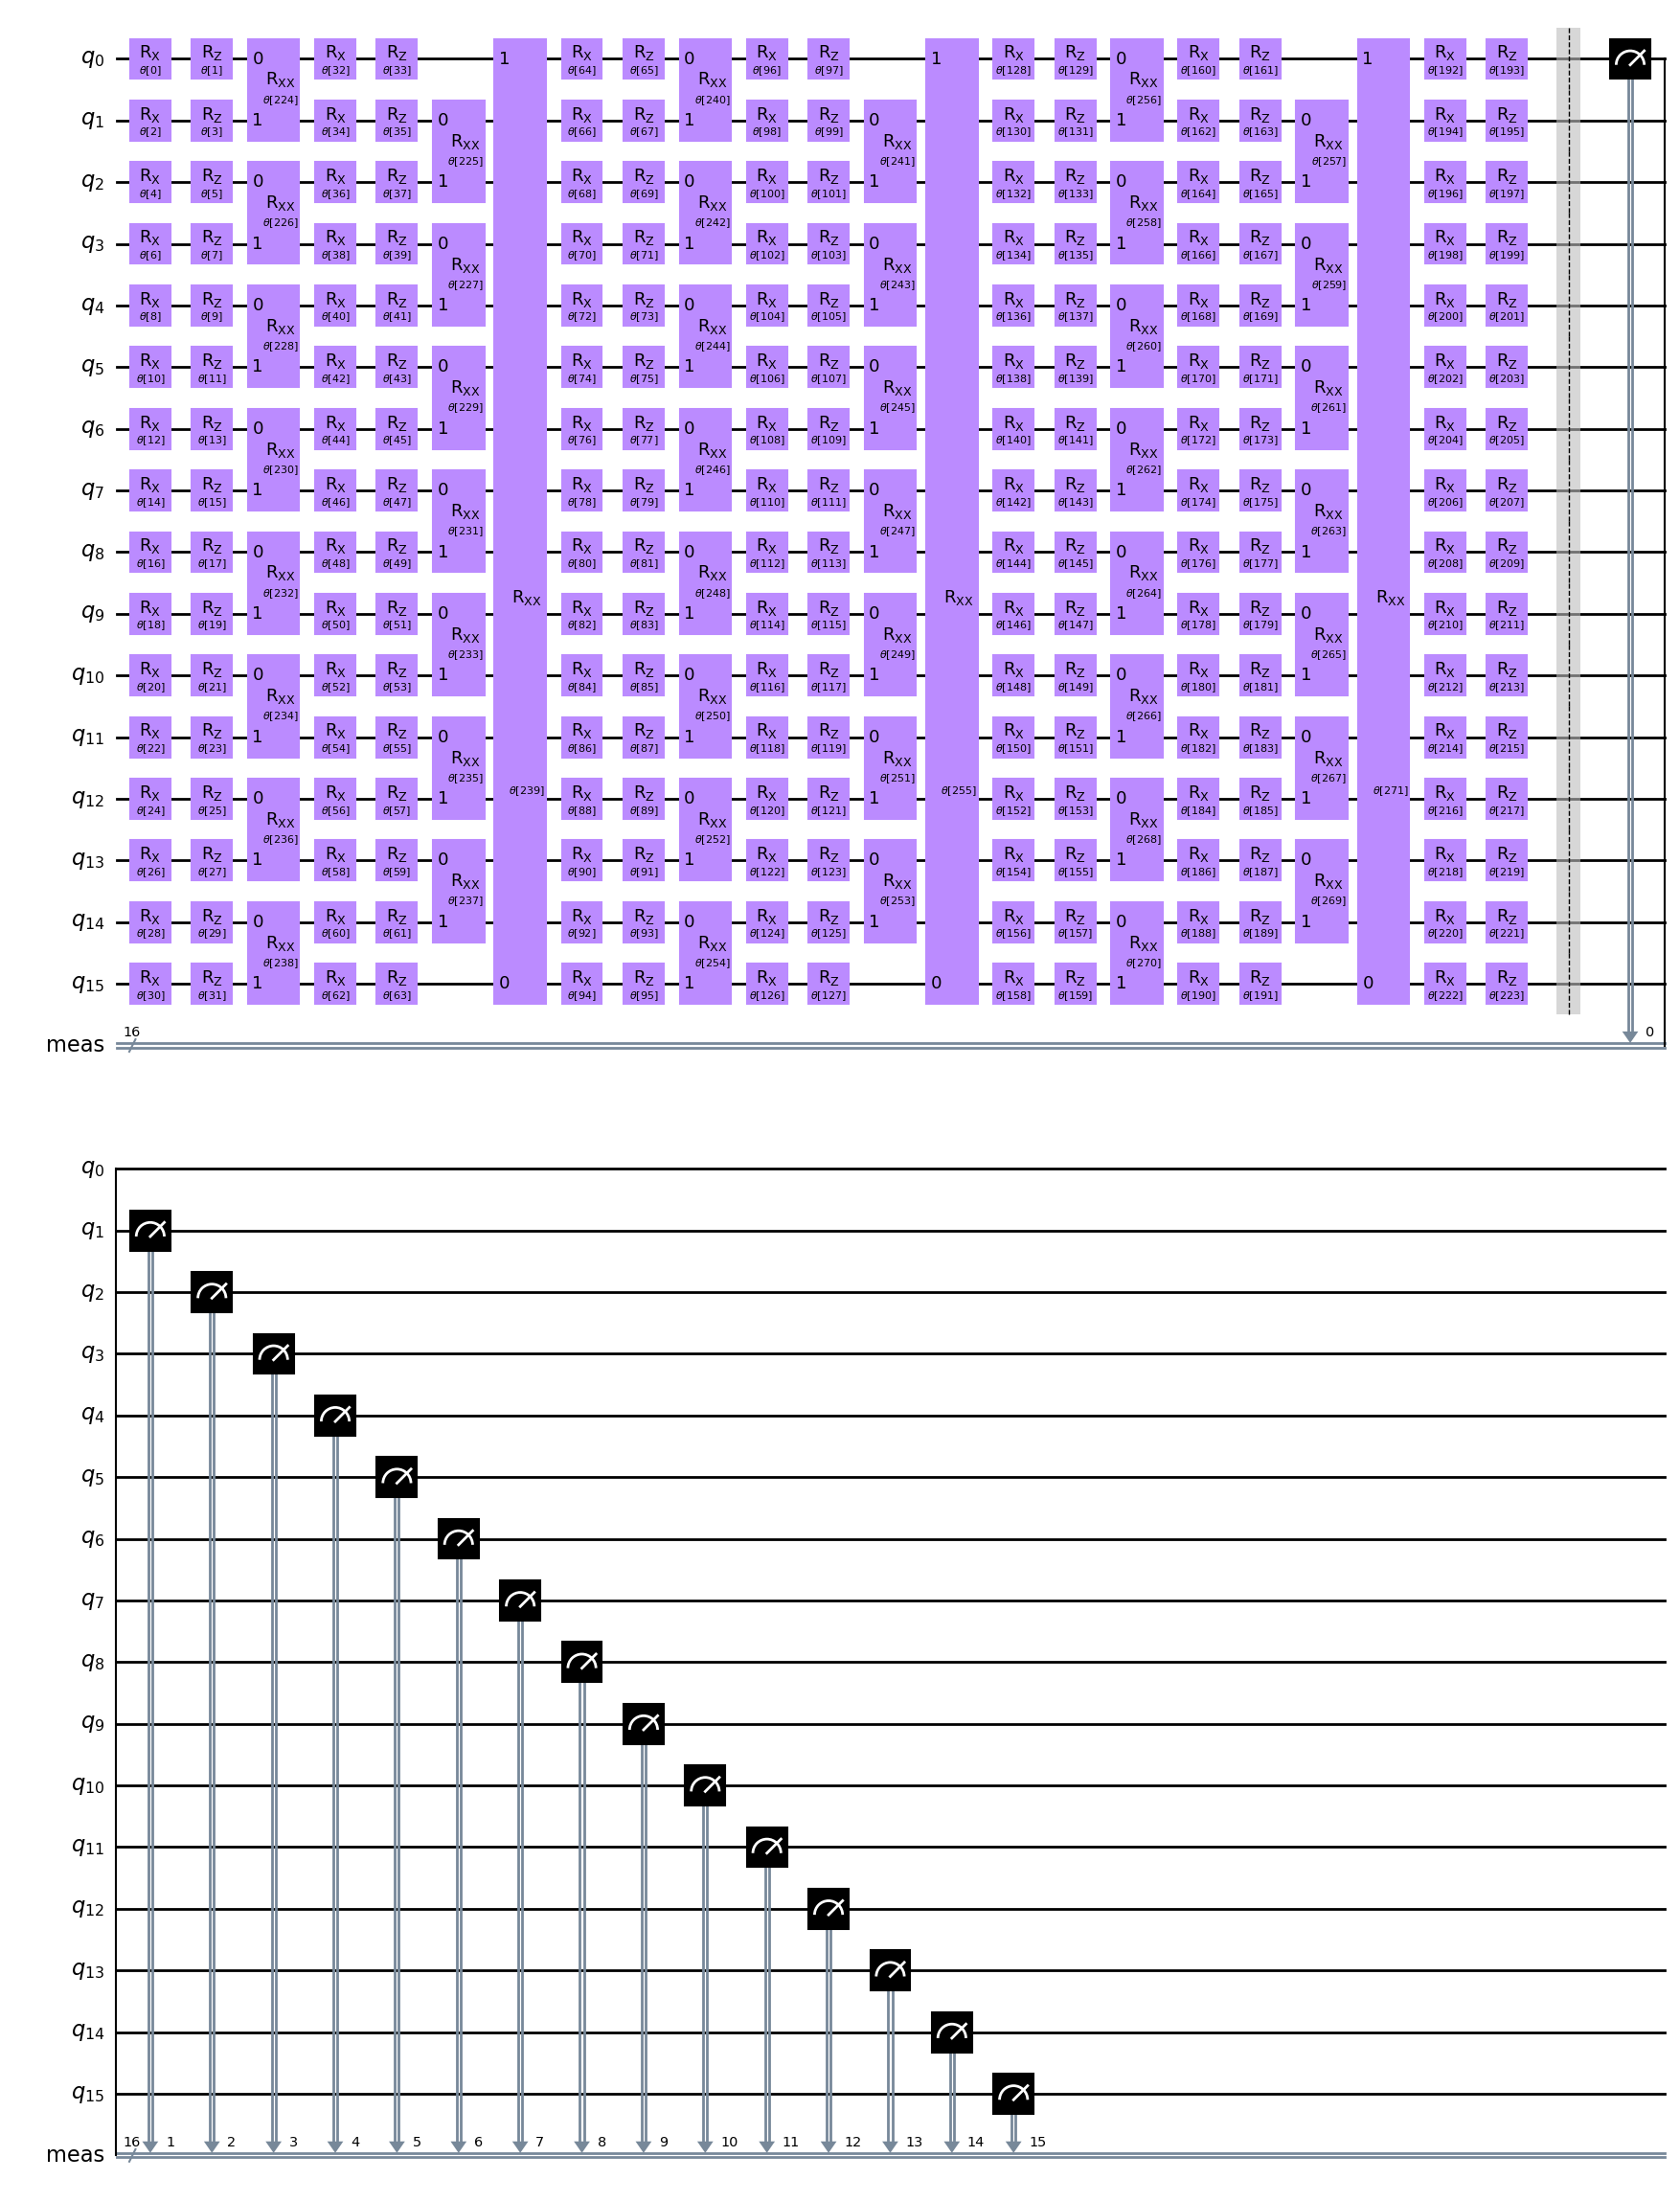

In [97]:
qc.draw(output="mpl", style="clifford")


In [98]:
# simulator = AerSimulator(device="GPU")
simulator = AerSimulator()
rng = np.random.default_rng()

In [ ]:
def string_to_array(string):
    ls = []
    for c in string:
        ls.append(int(c))
    return ls

def key_convert(key):
    new_key = ""
    for i in range(0, len(key), Q_PER_SITE):
        val = int(key[i:i+Q_PER_SITE], 2)  # 3-bit binary → int [0–7]
        new_key += chr(val)
    return new_key

def dict_to_ndarray(dict_data):
    data_array = []

    for result_str, count in dict_data.items():
        result = [ord(c) for c in result_str]  # Convert chars back to int (e.g., chr(11) → 11)
        for _ in range(count):
            data_array.append(result)

    return np.array(data_array, dtype=np.float32)

def generate(parameters, shots):
    circuit = qc.assign_parameters({par_weights:parameters})
    job = simulator.run(circuit, shots=shots)
    result = job.result()
    counts_dict = result.get_counts()
    result_dict = {key_convert(key): val for key, val in counts_dict.items()}
    result_arr  = dict_to_ndarray(result_dict)
    #result_arr_rescaled = result_arr * 1/4 + 1/8
    #result_arr_spread   = result_arr_rescaled + rng.uniform(-1/8, 1/8, size = result_arr_rescaled.shape)

    result_arr_rescaled = result_arr / 15.0

    result_arr_spread = result_arr_rescaled + rng.uniform(-1/16, 1/16, size=result_arr_rescaled.shape)
    result_arr_spread = np.clip(result_arr_spread, 0, 1)
    return result_arr_spread * max_data


In [100]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 2.0)
        m.bias.data.uniform_(-1.0, 1.0)
    elif classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

# class Discriminator(nn.Module):
#     def __init__(self):
#         super(Discriminator, self).__init__()
#         self.main = nn.Sequential(
#             nn.Linear(OUT_DIM, 32),
#             nn.LeakyReLU(0.2),
#             nn.Linear(32, 16),
#             nn.LeakyReLU(0.2),
#             nn.Linear(16, 8),
#             nn.LeakyReLU(0.2),
#             nn.Linear(8, 1),
#             nn.Sigmoid()
#         )
    
#     def forward(self, input):
#         return self.main(input)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(OUT_DIM, 12),
            nn.LeakyReLU(0.2),
            # nn.Linear(16, 8),
            # nn.LeakyReLU(0.2),
            nn.Linear(12, 6),
            nn.LeakyReLU(0.2),
            nn.Linear(6, 1),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        return self.main(input)

In [101]:
# Create the discriminator
netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)

# # Initialize BCELoss function
criterion = nn.BCELoss()

# def criterion(output, label):
#     return torch.mean(torch.square(output - label))

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))

Discriminator(
  (main): Sequential(
    (0): Linear(in_features=4, out_features=12, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=12, out_features=6, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=6, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [102]:
# qc0 = qc.assign_parameters({par_weights:params})
# job = simulator.run(qc0, shots=16)
# count_dict = job.result().get_counts()

In [103]:
# count_dict

In [104]:
# generate(params, 10)

In [105]:
def updateD(real_batch, fake_batch):
    netD.zero_grad()
    real_batch = real_batch.to(device)
    b_size = real_batch.shape[0]
    label = torch.full((b_size,), REAL_LABEL, dtype=torch.float, device=device)
    output = netD(real_batch).view(-1)
    errD_real = criterion(output, label)
    errD_real.backward()
    D_x = output.mean().item()

    fake_batch = torch.tensor(fake_batch, device=device, dtype=torch.float)
    label.fill_(FAKE_LABEL)
    output = netD(fake_batch.detach()).view(-1)
    errD_fake = criterion(output, label)
    errD_fake.backward()
    D_g = output.mean().item()
    errD = errD_real + errD_fake
    # Update D
    optimizerD.step()
    return errD.item(), D_x, D_g


In [106]:
class GOptimizer:
    def __init__(self, alpha=spsa_alpha, gamma=spsa_gamma, c=spsa_c, A=spsa_A, a=spsa_a, netD=netD, gen=generate, loss_func = criterion, rng=rng):
        self.k = 0
        self.alpha = alpha
        self.gamma = gamma
        self.c     = c
        self.A     = A
        self.a     = a
        self.netD  = netD
        self.gen   = gen
        self.loss_func = loss_func
        self.rng = rng

    def calculate_loss(self, parameters, shots):
        fake_batch = self.gen(parameters, shots)
        fake_batch = torch.tensor(fake_batch, device=device, dtype=torch.float)
        with torch.no_grad():
            output = self.netD(fake_batch).view(-1)
        label = torch.full((shots,), REAL_LABEL, dtype=torch.float, device=device)
        return self.loss_func(output, label).item()

    def stochastic_gradient(self, parameters, shots):
        self.k += 1

        ck = self.c / self.k**self.gamma
        param_deltas = rng.choice([-1., 1.], size = parameters.shape) * ck
        params_plus = parameters + param_deltas
        params_minus = parameters - param_deltas

        loss_plus = self.calculate_loss(params_plus, shots)
        loss_minus = self.calculate_loss(params_minus, shots)

        return (loss_plus - loss_minus) / 2 / param_deltas

    def next_params(self, parameters, shots):
        grad = self.stochastic_gradient(parameters, shots)

        ak = self.a / (self.A + self.k) ** self.alpha
        return parameters - ak * grad




In [107]:
# # pretraining for discriminator
# for epoch in range(1):
#     for i, data in enumerate(data_loader):


#         # optimize the discriminator
#         data = data.to(device)
#         fake = generate(rng.standard_normal(n_parameters), shots=d_batch_size)
#         updateD(data, fake)

In [108]:
g_optimizer = GOptimizer()
params_init = rng.standard_normal(n_parameters)
params = params_init

In [109]:
print(params)

[-0.31745829 -0.18033566 -0.99396647  0.84371895 -0.25389026 -0.72340072
 -0.44861135  0.20919037 -0.69182018 -0.36247484 -0.68286441  0.54319644
 -0.23854941 -1.6998017   0.72552237  0.39095514 -0.11689963 -0.59901603
  0.50450406 -0.85923493 -1.01445677 -1.49819603 -0.55985968  0.62764823
 -0.41059132 -0.32922221 -0.00731084  0.89303149  0.88518678  2.03319295
 -1.11372198  0.49815651 -1.09137862 -0.51237459  0.15640835 -0.15300886
 -0.81406871 -0.68030005  0.99874995 -1.30205184 -1.0685663   1.33423426
 -0.86038715  0.2743632  -0.13009821  0.67068442  0.27791147 -0.23193984
  1.59237526  0.96623888 -0.48686791  1.36326436  0.20461799  1.14090771
  0.41363821 -0.86210833 -1.0226555   1.12358617 -1.80754866 -0.37946909
  0.37265278  0.12396107  0.76007123  0.73695714 -1.17840161 -1.88829839
 -1.78247468 -0.35126155 -0.47577035  0.01832524 -1.03511687 -0.22520692
  0.85474927 -0.20840512  0.39086172  0.57618313  1.47566061 -0.75091691
  0.86655157 -0.20780442 -0.99355159 -0.25192475  0

In [110]:
for epoch in range(d_pretrain_epoch):
    for i, data in enumerate(data_loader):
        # optimize the discriminator
        data = data.to(device)
        fake = generate(params, shots=data.shape[0])
        loss_D, D_x, D_g = updateD(data, fake)

In [111]:


G_losses = []
D_losses = []

start = time.time()
now = start

print("Starting Training Loop...")

for epoch in range(n_epoch):
    for i, data in enumerate(data_loader):


        
        # optimize the discriminator
        data = data.to(device)
        fake = generate(params, shots=data.shape[0])
        for j in range(d_repeats):
            loss_D, D_x, D_g = updateD(data, fake)

        # this part is not important
        with torch.no_grad():
            output = netD(torch.tensor(fake, device=device, dtype=torch.float)).view(-1)
            labels = torch.full((fake.shape[0],), REAL_LABEL, dtype=torch.float, device=device)
            loss_G = criterion(output, labels)


        if epoch < epoch_1:
            g_repeats = g_repeats_1
        else:
            g_repeats = g_repeats_2
        # optimize the generator
        for j in range(g_repeats):
            params = g_optimizer.next_params(params, g_batch_size)


        # print output
        if i%10 == 0:
            G_losses.append(loss_G)
            D_losses.append(loss_D)

            last, now = now, time.time()
            print(f"[{epoch+1}/{n_epoch}][{i}/{len(data_loader)}]\tLossD: {loss_D:.4f}\tLossG: {loss_G:.4f}\t" +
                f"D(x): {D_x:.4f}\tD(G(x)): {D_g:.4f}\tTime: {now-last:.1f}s")
        


Starting Training Loop...
[1/200][0/64]	LossD: 3.8085	LossG: 1.4727	D(x): 0.7258	D(G(x)): 0.6934	Time: 0.1s
[1/200][10/64]	LossD: 2.8004	LossG: 2.7975	D(x): 0.6648	D(G(x)): 0.4724	Time: 0.8s
[1/200][20/64]	LossD: 3.8836	LossG: 0.7490	D(x): 0.6262	D(G(x)): 0.7563	Time: 0.8s
[1/200][30/64]	LossD: 2.8632	LossG: 1.6265	D(x): 0.7385	D(G(x)): 0.5832	Time: 0.8s
[1/200][40/64]	LossD: 3.7569	LossG: 2.0110	D(x): 0.7774	D(G(x)): 0.6021	Time: 0.8s
[1/200][50/64]	LossD: 3.4803	LossG: 1.8744	D(x): 0.7145	D(G(x)): 0.6498	Time: 0.7s
[1/200][60/64]	LossD: 1.6646	LossG: 3.1755	D(x): 0.6701	D(G(x)): 0.3884	Time: 0.8s
[2/200][0/64]	LossD: 3.4876	LossG: 2.2282	D(x): 0.7583	D(G(x)): 0.5490	Time: 0.3s
[2/200][10/64]	LossD: 2.7238	LossG: 2.2611	D(x): 0.7915	D(G(x)): 0.5399	Time: 0.7s
[2/200][20/64]	LossD: 3.6229	LossG: 1.7641	D(x): 0.6615	D(G(x)): 0.6548	Time: 0.9s
[2/200][30/64]	LossD: 1.7605	LossG: 3.0843	D(x): 0.6415	D(G(x)): 0.3979	Time: 1.0s
[2/200][40/64]	LossD: 2.6938	LossG: 2.1253	D(x): 0.6567	D(G(x))

In [112]:
finish = time.time()
print(f"Training takes {round(finish-start)}s.")

Training takes 2011s.


In [113]:
print(params)

[-6.57757079e-01 -7.05469080e-01 -1.06206388e+00  1.02922556e+00
 -6.18227398e-01 -1.01456859e+00 -8.87222413e-01 -4.93787242e-01
 -8.06542531e-01 -5.10046468e-01 -1.43235014e+00  6.75189326e-01
  1.15785730e-03 -1.38366918e+00  6.45823772e-01  6.30231090e-01
  1.82049932e-01 -4.20622111e-01  4.40990845e-02 -7.39800383e-01
 -1.28910182e+00 -9.62841302e-01 -1.39353551e+00  1.03049110e+00
 -8.05049117e-01 -1.67723631e-01 -5.42219811e-01  8.41120780e-01
  5.65984687e-01  2.30060158e+00 -1.54393197e+00  3.93100695e-01
 -1.11784716e+00 -1.06353645e+00  3.17773684e-01  1.44222868e-01
 -9.76174741e-01 -1.00367639e+00  9.43648076e-01 -1.54957551e+00
 -1.35171012e+00  1.81366528e+00 -8.88389940e-01  3.49509466e-01
 -3.63222059e-01  6.62977121e-01  5.84942168e-01 -1.27805172e-01
  1.26202941e+00  7.37649992e-01 -9.93448875e-01  1.02581824e+00
  5.24870228e-01  1.24267663e+00  7.15076732e-02 -8.35084286e-01
 -8.83955783e-01  1.11920688e+00 -1.92132230e+00 -2.23871832e-01
  1.04833789e+00 -1.36677

In [114]:
netD.eval()

Discriminator(
  (main): Sequential(
    (0): Linear(in_features=4, out_features=12, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=12, out_features=6, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=6, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

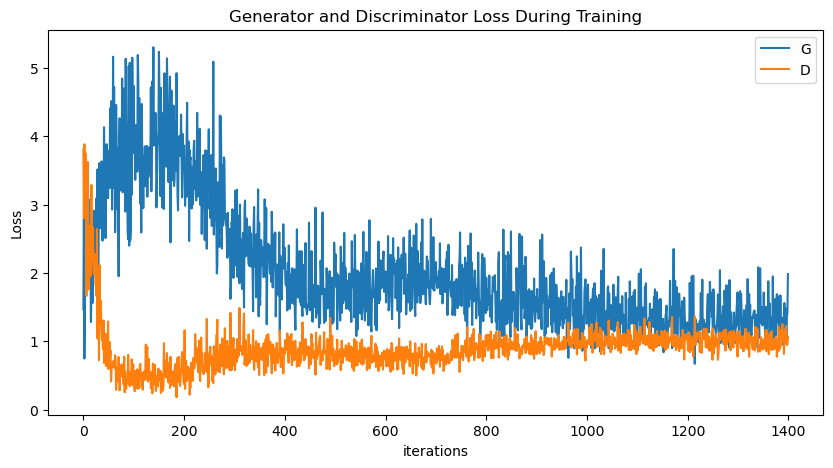

<Figure size 640x480 with 0 Axes>

In [115]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.savefig(os.path.join(save_folder, "loss.png"))

In [116]:
n_rows = 2
n_cols = 4

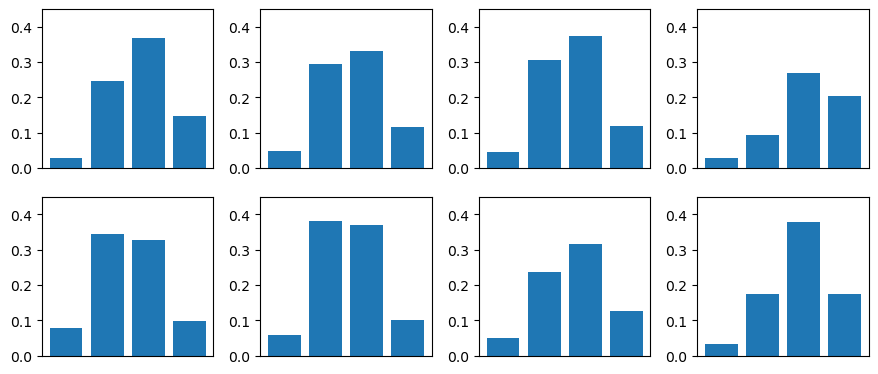

In [117]:
real_batch = next(iter(data_loader))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(9, 4))

for i, ax in enumerate(axes.flatten()):
    # ax.axis("off")
    # ax.plot(real_batch[i].cpu())
    fig.tight_layout()
    ax.set(ylim=[0, max_data + 0.05])
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.set_xticks([])
    # ax.xlabel("off")
    ax.bar(range(4), real_batch[i].cpu())
    # ax.imshow(real_batch[i].reshape(2, 2).cpu(), cmap="binary")
fig.savefig(os.path.join(save_folder, "real_images.png"))


In [118]:
# real_batch = next(iter(data_loader))

# fig, axes = plt.subplots(n_rows, n_cols)

# for i, ax in enumerate(axes.flatten()):
#     ax.axis("off")
#     ax.imshow(real_batch[i].reshape(2, 2).cpu(), cmap="binary")

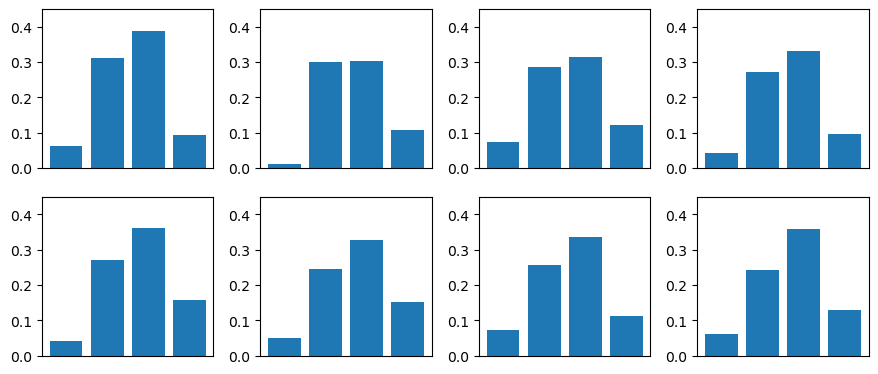

In [119]:
b_size = n_rows * n_cols

fake_batch = generate(params, b_size)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(9, 4))
for i, ax in enumerate(axes.flatten()):
    # ax.axis("off")
    fig.tight_layout()
    ax.set(ylim=[0, max_data + 0.05])
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.set_xticks([])
    ax.bar(range(4), fake_batch[i])
fig.savefig(os.path.join(save_folder, "fake_images.png"))


In [120]:
# b_size = n_rows * n_cols

# fake_batch = generate(params, b_size)

# fig, axes = plt.subplots(n_rows, n_cols)
# for i, ax in enumerate(axes.flatten()):
#     ax.axis("off")
#     ax.imshow(fake_batch[i].reshape(2, 2), cmap="binary")

In [121]:
sample_size = 900
data_index = torch.randperm(data_true.shape[0])[:sample_size]
real_samples = data_true[data_index]

fake_samples = generate(params, sample_size)

np.savez(save_folder + "/samples.npz", 
    real_samples = real_samples.cpu(), 
    fake_samples = fake_samples
)

In [122]:
with torch.no_grad():
    real_scores = netD(real_samples).cpu()
    fake_scores = netD(torch.tensor(fake_samples, device=device, dtype=torch.float)).cpu()

In [123]:
print(np.mean(real_scores.numpy()))
print(np.mean(fake_scores.numpy()))


0.6496258
0.36311176


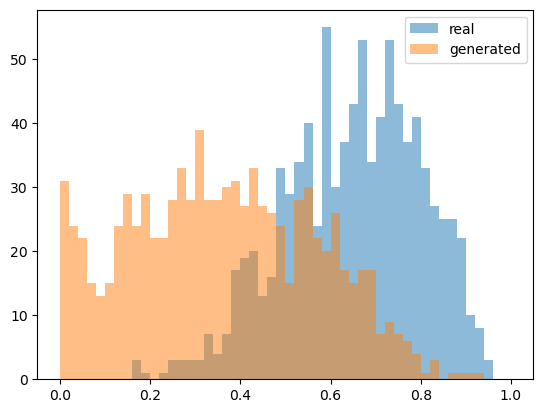

In [124]:
fig, ax = plt.subplots()



ax.hist(real_scores.view(-1), bins = 50, range=(0, 1), color = plt.cm.tab10(0), alpha=0.5, label="real")
ax.hist(fake_scores.view(-1), bins = 50, range=(0, 1), color = plt.cm.tab10(1), alpha=0.5, label="generated")

ax.legend()

fig.savefig(os.path.join(save_folder, "hist.png"))


In [125]:
for p in netD.parameters():
    print(p)

Parameter containing:
tensor([[-4.3545,  0.1505,  3.6997,  4.6981],
        [-3.4041,  2.1455, -1.1170,  1.5773],
        [ 1.3822,  0.7312,  0.9564,  4.6737],
        [-0.5674, -1.0525, -2.1567,  0.7056],
        [ 2.8601,  0.7840,  0.0391,  1.5654],
        [-2.6600,  1.5985, -1.7958,  1.8925],
        [ 3.1452,  2.1257,  0.1745, -2.2171],
        [ 1.3328,  0.5440,  0.1698,  0.6750],
        [ 1.1366, -2.0088, -1.4147,  1.1720],
        [ 0.6113, -1.2129,  2.3253, -0.3149],
        [ 2.0863,  4.3487, -2.3121, -0.9092],
        [-2.2310, -2.8464,  1.3815, -0.2755]], requires_grad=True)
Parameter containing:
tensor([ 0.1449, -0.2373, -1.0693, -0.0567, -0.2780,  0.6115,  1.1251, -1.0651,
        -0.1571, -0.4743, -0.4128, -0.5499], requires_grad=True)
Parameter containing:
tensor([[ 0.0169,  3.4180, -0.5609, -1.6797, -0.6408, -0.4160,  1.9604, -2.7065,
          3.8115,  1.8529, -2.2939, -1.0700],
        [ 1.1820, -1.5145, -0.6977, -0.2546, -0.2017, -5.1616, -3.6336, -1.0810,
        

In [126]:
# json_path = data_path[:-4] + ".json"
# with open(json_path, 'r') as f:
#     real_data_dict = json.load(f)

# def np_to_dict(result_np):
#     result_dict = {}
#     for line in result_np:
#         str_key = ""
#         for i in line:  # reversing the order to match qiskit notation
#             str_key+=(str(i))
#         current_value = result_dict.get(str_key, 0)
#         result_dict[str_key] = current_value + 1
#     return result_dict

# fake_data = generate(params, 20480)

# fake_data_dict = np_to_dict(fake_data)

# all_keys = (set(real_data_dict.keys())) | (set(fake_data_dict.keys()))

# real_counts = []
# fake_counts = []

# for k in all_keys:
#     real_counts.append(real_data_dict.get(k, 0))
#     fake_counts.append(fake_data_dict.get(k, 0))

# real_counts = np.array(real_counts)
# fake_counts = np.array(fake_counts)

# real_probs = real_counts / np.sum(real_counts)
# fake_probs = fake_counts / np.sum(fake_counts)

# mixed_probs = (real_probs + fake_probs) / 2 # here, every entry of mixed_probs are positive

# # Note, mixed_probs is all positive. That's why you can use nan_to_num to deal with zero entries in real_probs or fake_probs
# dl_r = np.sum(real_probs * np.nan_to_num(np.log(real_probs / mixed_probs)))
# dl_f = np.sum(fake_probs * np.nan_to_num(np.log(fake_probs / mixed_probs)))

# jl_div = (dl_r + dl_f) / 2

# print(f"JL-divergens is {jl_div}")


In [127]:
# train a standalone discriminator to evaluate the performance of the GAN "objectively"
class Evaluator(nn.Module):
    def __init__(self):
        super(Evaluator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(OUT_DIM, 16),
            # nn.LeakyReLU(0.2),
            # nn.Linear(32, 16),
            nn.LeakyReLU(0.2),
            nn.Linear(16, 8),
            nn.LeakyReLU(0.2),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        return self.main(input)

In [128]:
netEv = Evaluator().to(device)
netEv.apply(weights_init)

optimizer_ev = optim.Adam(netEv.parameters(), lr=lr, betas=(0.5, 0.999))
loss_ev = nn.BCELoss()
print(netEv)

Evaluator(
  (main): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=8, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [129]:
batch_size_ev = 16

In [130]:
real_samples_np = real_samples.cpu().numpy()
fake_samples_np = fake_samples

samples = np.concatenate((real_samples_np, fake_samples_np))

real_labels = np.repeat(REAL_LABEL, real_samples_np.shape[0])
fake_labels = np.repeat(FAKE_LABEL, fake_samples_np.shape[0])
labels = np.concatenate((real_labels, fake_labels))

X_train, X_rest, y_train, y_rest = train_test_split(
    samples, labels, train_size = 0.6, shuffle = True, stratify = labels
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_rest, y_rest, test_size = 0.5, shuffle = True, stratify = y_rest
)

X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
X_valid = torch.tensor(X_valid, dtype=torch.float32, device=device)
X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
y_train = torch.tensor(y_train, dtype=torch.float32, device=device)
y_valid = torch.tensor(y_valid, dtype=torch.float32, device=device)
y_test = torch.tensor(y_test, dtype=torch.float32, device=device)


data_loader_ev = torch.utils.data.DataLoader(list(zip(X_train, y_train)), batch_size = batch_size_ev, shuffle = True)


In [131]:
valid_losses = []
train_losses = []
iters = 0

netEv.train()
 

print("Starting the training loop")
for epoch in range(n_epoch):
    for i, data in enumerate(data_loader_ev):
        netEv.zero_grad()
        X_batch = data[0].to(device)
        y_batch = data[1].to(device)
        prediction_batch = netEv(X_batch).view(-1)
        err = loss_ev(prediction_batch, y_batch)
        err.backward()
        optimizer_ev.step()

        if i%50 == 0:
            netEv.eval()
            with torch.no_grad():
                prediction_valid = netEv(X_valid).view(-1)
                prediction_train = netEv(X_train).view(-1)
            train_loss = loss_ev(prediction_train, y_train).item()
            valid_loss = loss_ev(prediction_valid, y_valid).item()
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
            valid_acc  = torch.isclose(torch.round(prediction_valid), y_valid).sum().item()/len(y_valid)
            netEv.train()

            print(
                f"[{epoch+1}/{n_epoch}][{i}/{len(data_loader)}]\tLoss train: {train_loss:.3f}\tLoss valid: {valid_loss:.3f}\tLoss acc: {valid_acc:.3f}"
            )

Starting the training loop
[1/200][0/64]	Loss train: 49.841	Loss valid: 49.517	Loss acc: 0.500
[1/200][50/64]	Loss train: 49.842	Loss valid: 49.521	Loss acc: 0.500
[2/200][0/64]	Loss train: 49.841	Loss valid: 49.516	Loss acc: 0.500
[2/200][50/64]	Loss train: 49.449	Loss valid: 49.277	Loss acc: 0.500
[3/200][0/64]	Loss train: 49.446	Loss valid: 49.271	Loss acc: 0.500
[3/200][50/64]	Loss train: 49.358	Loss valid: 49.026	Loss acc: 0.500
[4/200][0/64]	Loss train: 49.352	Loss valid: 49.019	Loss acc: 0.500
[4/200][50/64]	Loss train: 49.106	Loss valid: 48.300	Loss acc: 0.500
[5/200][0/64]	Loss train: 48.945	Loss valid: 48.291	Loss acc: 0.500
[5/200][50/64]	Loss train: 43.722	Loss valid: 45.154	Loss acc: 0.500
[6/200][0/64]	Loss train: 12.620	Loss valid: 15.138	Loss acc: 0.494
[6/200][50/64]	Loss train: 0.999	Loss valid: 0.997	Loss acc: 0.581
[7/200][0/64]	Loss train: 0.979	Loss valid: 0.971	Loss acc: 0.569
[7/200][50/64]	Loss train: 0.955	Loss valid: 0.942	Loss acc: 0.572
[8/200][0/64]	Loss t

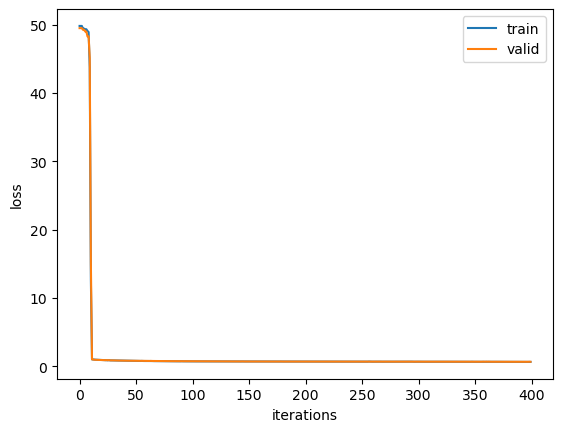

In [132]:
fig, ax = plt.subplots()
ax.plot(train_losses, label="train")
ax.plot(valid_losses, label="valid")
ax.set(xlabel="iterations", ylabel="loss")
ax.legend()

In [133]:
netEv.eval()

with torch.no_grad():
    prediction_test = netEv(X_test).view(-1)

test_acc = torch.isclose(torch.round(prediction_test), y_test).sum().item() / len(y_test)

print(f"Test accuracy: {test_acc}")

Test accuracy: 0.65


In [134]:
print(f"AUC score is {roc_auc_score(y_test, prediction_test)}")

AUC score is 0.7132716049382717


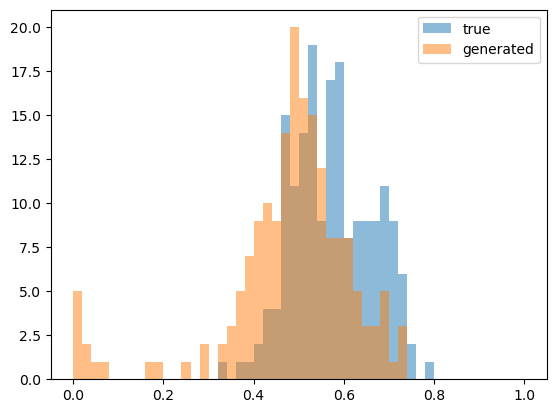

In [135]:
true_indices = y_test.isclose(torch.tensor(1.0))
fake_indices = y_test.isclose(torch.tensor(0.0))

pred_true = prediction_test[true_indices]
pred_fake = prediction_test[fake_indices]

fig, ax = plt.subplots()
ax.hist(pred_true.cpu(), bins = 50, range=(0, 1), color = plt.cm.tab10(0), alpha=0.5, label="true")
ax.hist(pred_fake.cpu(), bins = 50, range=(0, 1), color = plt.cm.tab10(1), alpha=0.5, label="generated")
ax.legend()

None